In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# Définition du Dataset pour le langage des signes
class SignLanguageDataset(Dataset):
    def __init__(self, csv_file):
        # Chargement des données à partir d'un fichier CSV
        self.data = pd.read_csv(csv_file)
        # Les étiquettes sont la première colonne
        self.labels = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)
        # Les images sont les colonnes restantes, normalisées entre 0 et 1
        self.images = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 28, 28) / 255.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label


In [3]:
# Définition du modèle RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Définition de la couche RNN
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # Couche de sortie entièrement connectée
        self.fc = nn.Linear(hidden_size * 28, num_classes)

    def forward(self, x):
        # Initialisation de l'état caché
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Passage à travers la couche RNN
        out, _ = self.rnn(x, h0)
        # Redimensionnement pour la couche entièrement connectée
        out = out.reshape(out.size(0), -1)
        # Passage par la couche entièrement connectée
        out = self.fc(out)
        return out


In [4]:
# Chargement des datasets d'entraînement et de test
train_dataset = SignLanguageDataset('../../data/sign_mnist_train.csv')
test_dataset = SignLanguageDataset('../../data/sign_mnist_test.csv')

# Définition des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Vérification de la disponibilité de CUDA pour le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paramètres du modèle
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 26
num_epochs = 10
learning_rate = 0.001

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = RNNModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Listes pour stocker les précisions d'entraînement et de test
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []


In [5]:
# Boucle d'entraînement
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Passage avant
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Rétropropagation et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calcul de la précision sur le jeu d'entraînement
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(loss.item())
    
    # Calcul de la précision sur le jeu de test
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    test_losses.append(loss.item())
    
    # Affichage de l'évolution des performances
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')


Epoch [1/10], Loss: 0.2838, Train Accuracy: 86.64%, Test Accuracy: 74.27%
Epoch [2/10], Loss: 0.1118, Train Accuracy: 97.61%, Test Accuracy: 80.54%
Epoch [3/10], Loss: 0.1718, Train Accuracy: 95.25%, Test Accuracy: 78.76%
Epoch [4/10], Loss: 0.0022, Train Accuracy: 100.00%, Test Accuracy: 86.03%
Epoch [5/10], Loss: 0.0021, Train Accuracy: 100.00%, Test Accuracy: 85.68%
Epoch [6/10], Loss: 0.0014, Train Accuracy: 100.00%, Test Accuracy: 86.13%
Epoch [7/10], Loss: 0.0013, Train Accuracy: 100.00%, Test Accuracy: 86.52%
Epoch [8/10], Loss: 0.0005, Train Accuracy: 100.00%, Test Accuracy: 86.73%
Epoch [9/10], Loss: 0.0004, Train Accuracy: 100.00%, Test Accuracy: 86.54%
Epoch [10/10], Loss: 0.0005, Train Accuracy: 100.00%, Test Accuracy: 86.94%


In [6]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

save_model(model, 'rnn_final.pth')

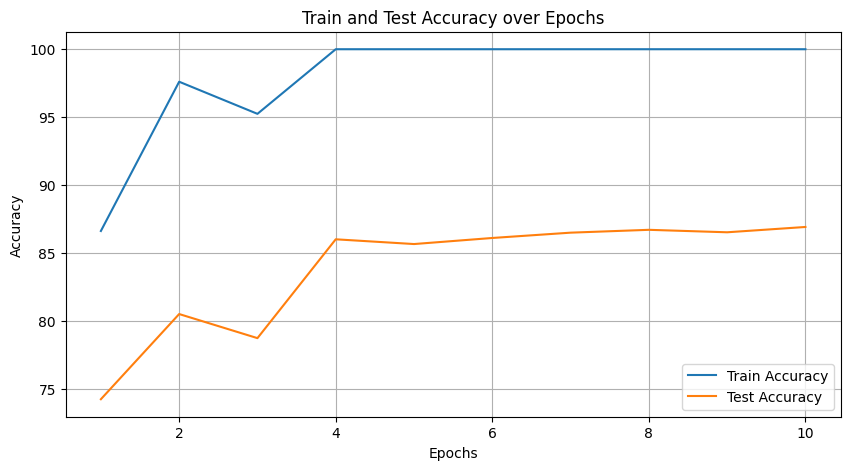

In [7]:
# Visualisation des courbes de précision
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()


In [8]:
# Évaluation finale et matrice de confusion
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
    
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')
    

Accuracy of the model on the test images: 86.94%


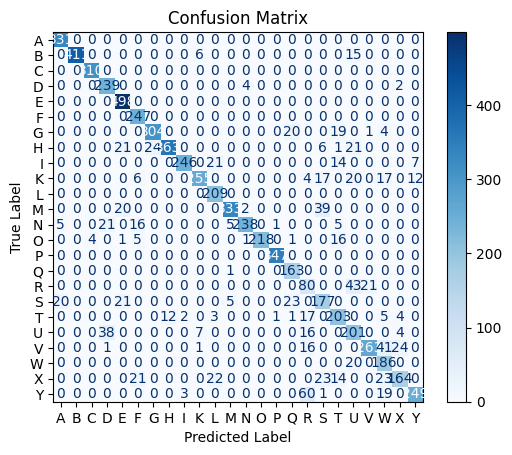

In [9]:
# Génération et affichage de la matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Définition des lettres représentant chaque classe
class_labels = list("ABCDEFGHIKLMNOPQRSTUVWXY")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Réutilisation de la classe SignLanguageDataset
class SignLanguageDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.labels = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)
        self.images = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 1, 28, 28) / 255.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [11]:
# Définition du modèle CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 26)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [12]:
# Chargement des datasets
train_dataset = SignLanguageDataset('../../data/sign_mnist_train.csv')
test_dataset = SignLanguageDataset('../../data/sign_mnist_test.csv')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paramètres du modèle CNN
cnn_model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_train_accuracies = []
cnn_test_accuracies = []
cnn_train_losses = []
cnn_test_losses = []

In [13]:
# Boucle d'entraînement du CNN
for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    cnn_train_losses.append(running_loss / len(train_loader))
    
    # Calcul de la précision et de la perte sur le jeu d'entraînement
    cnn_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        cnn_train_accuracies.append(train_accuracy)
        cnn_train_losses.append(running_loss / len(train_loader))
    
    # Calcul de la précision et de la perte sur le jeu de test
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    cnn_test_accuracies.append(test_accuracy)
    cnn_test_losses.append(running_loss / len(test_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')
    

Epoch [1/10], Loss: 0.3922, Train Accuracy: 90.68%, Test Accuracy: 80.74%
Epoch [2/10], Loss: 0.0998, Train Accuracy: 97.96%, Test Accuracy: 87.09%
Epoch [3/10], Loss: 0.0637, Train Accuracy: 99.71%, Test Accuracy: 91.12%
Epoch [4/10], Loss: 0.0126, Train Accuracy: 99.97%, Test Accuracy: 91.93%
Epoch [5/10], Loss: 0.0184, Train Accuracy: 100.00%, Test Accuracy: 91.51%
Epoch [6/10], Loss: 0.1472, Train Accuracy: 99.99%, Test Accuracy: 90.96%
Epoch [7/10], Loss: 0.0420, Train Accuracy: 100.00%, Test Accuracy: 91.89%
Epoch [8/10], Loss: 0.0024, Train Accuracy: 100.00%, Test Accuracy: 91.80%
Epoch [9/10], Loss: 0.0008, Train Accuracy: 99.99%, Test Accuracy: 93.06%
Epoch [10/10], Loss: 0.0020, Train Accuracy: 100.00%, Test Accuracy: 93.49%


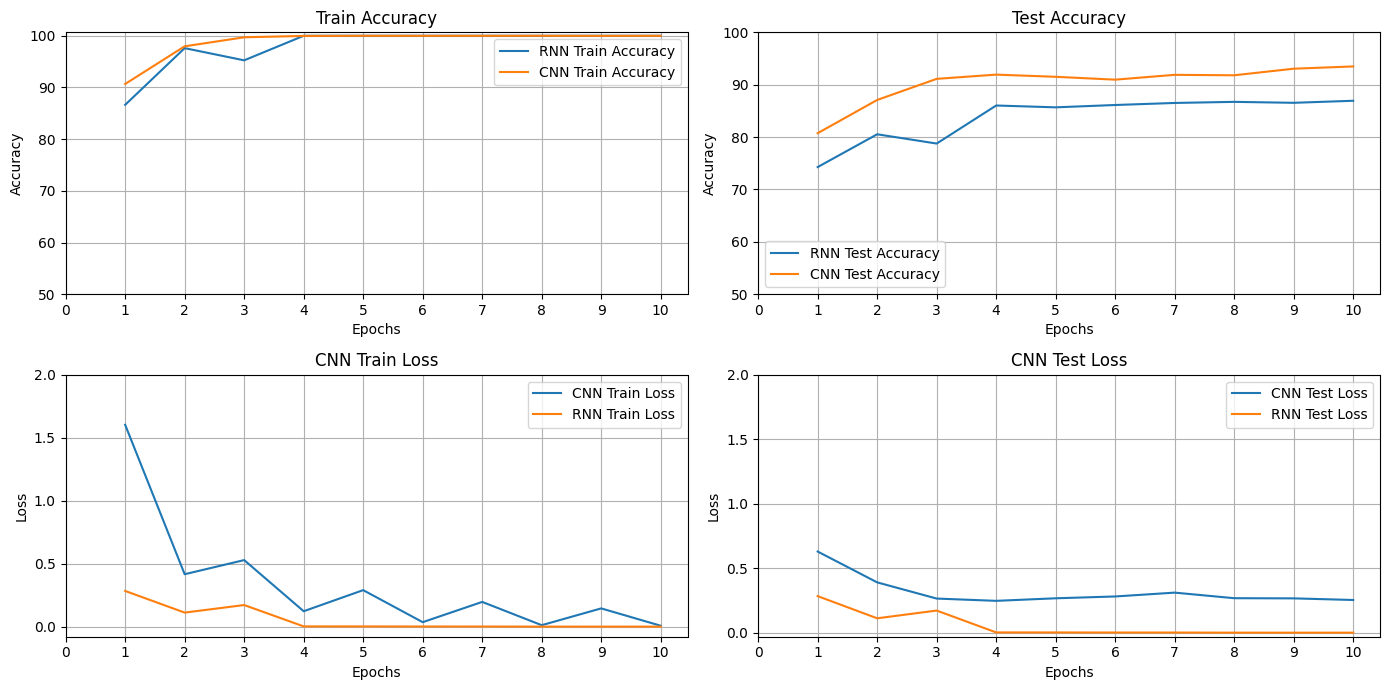

In [14]:
# Visualisation des courbes de précision et de perte pour le RNN et le CNN
plt.figure(figsize=(14, 7))


# Same scale for all plots
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies, label='RNN Train Accuracy')
plt.plot(range(1, num_epochs+1), cnn_train_accuracies, label='CNN Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, num_epochs+1))
plt.yticks(range(50, 101, 10))
plt.title('Train Accuracy')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs+1), test_accuracies, label='RNN Test Accuracy')
plt.plot(range(1, num_epochs+1), cnn_test_accuracies, label='CNN Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, num_epochs+1))
plt.yticks(range(50, 101, 10))
plt.title('Test Accuracy')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs+1), cnn_train_losses[:10], label='CNN Train Loss')
plt.plot(range(1, num_epochs+1), train_losses, label='RNN Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, num_epochs+1))
plt.yticks(np.arange(0, 2.5, 0.5))
plt.title('CNN Train Loss')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs+1), cnn_test_losses, label='CNN Test Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='RNN Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, num_epochs+1))
plt.yticks(np.arange(0, 2.5, 0.5))
plt.title('CNN Test Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()